In [1]:
import glob
import numpy as np
import pandas as pd
from pathlib import Path
from astropy.table import Table
import matplotlib.pyplot as plt

Inspect some of the candidates 

In [2]:
def read_fits(fname,drop_separators=False):
    """Load SNANA formatted data and cast it to a PANDAS dataframe
    Args:
        fname (str): path + name to PHOT.FITS file
        drop_separators (Boolean): if -777 are to be dropped
    Returns:
        (pandas.DataFrame) dataframe from PHOT.FITS file (with ID)
        (pandas.DataFrame) dataframe from HEAD.FITS file
    """

    # load photometry
    dat = Table.read(fname, format='fits')
    df_phot = dat.to_pandas()
    # failsafe
    if df_phot.MJD.values[-1] == -777.0:
        df_phot = df_phot.drop(df_phot.index[-1])
    if df_phot.MJD.values[0] == -777.0:
        df_phot = df_phot.drop(df_phot.index[0])

    # load header
    header = Table.read(fname.replace("PHOT", "HEAD"), format="fits")
    df_header = header.to_pandas()
    df_header["SNID"] = df_header["SNID"].astype(np.int32)

    # add SNID to phot for skimming
    arr_ID = np.zeros(len(df_phot), dtype=np.int32)
    # New light curves are identified by MJD == -777.0
    arr_idx = np.where(df_phot["MJD"].values == -777.0)[0]
    arr_idx = np.hstack((np.array([0]), arr_idx, np.array([len(df_phot)])))
    # Fill in arr_ID
    for counter in range(1, len(arr_idx)):
        start, end = arr_idx[counter - 1], arr_idx[counter]
        # index starts at zero
        arr_ID[start:end] = df_header.SNID.iloc[counter - 1]
    df_phot["SNID"] = arr_ID
    df_phot['BAND'] = df_phot.BAND.str.decode("utf-8")

    if drop_separators:
        df_phot = df_phot[df_phot.MJD != -777.000]

    return df_header, df_phot

In [3]:
# Type decoder useful for the future
dic_type_decoder = {87: "uLens-Single_PyLIMA" , 80: "RRLyrae" , 50: "KN_K17" , 25: "SNIc" , 21: "SNIb+HostXT_V19" , 60: "AGN" , 59: "PISN" , 30: "SNII-NMF" , 10: "SNIa-SALT2" , 46: "CART" , 82: "Mdwarf-flare" , 51: "KN_B19" , 20: "SNIb" , 31: "SNII" , 37: "SNIIb+HostXT_V19" , 83: "EB" , 88: "uLens-Single-GenLens" , 11: "SNIa-91bg" , 26: "SNIc+HostXT_V19" , 91: "d-Sct" , 45: "ILOT" , 89: "uLens-Binary" , 90: "Cepheid" , 12: "SNIax" , 40: "SLSN-I+host" , 27: "SNIcBL+HostXT_V19" , 42: "TDE" , 36: "SNIIn+HostXT_V19" , 84: "dwarf-nova" , 40: "SLSN-I_no_host" , 32: "SNII+HostXT_V19" , 35: "SNIIn-MOSFIT" }

In [4]:
# choose a folder where you simulation is
folder = 'FULL_ELASTICC_TRAIN/*/'

# inspect files (just taking the first file for each class)
list_files = glob.glob(f"{folder}/*001*PHOT*")

## read files

In [5]:
list_head = []
list_phot = []
for f in list_files:
    df_header, df_phot = read_fits(f, drop_separators=True)
    list_phot.append(df_phot)
    list_head.append(df_header)
df_phot = pd.concat(list_phot)
df_head = pd.concat(list_head)

In [6]:
# Check the columns of the photometry
df_phot.keys()

Index(['MJD', 'BAND', 'CCDNUM', 'FIELD', 'PHOTFLAG', 'PHOTPROB', 'FLUXCAL',
       'FLUXCALERR', 'PSF_SIG1', 'PSF_SIG2', 'PSF_RATIO', 'SKY_SIG',
       'SKY_SIG_T', 'RDNOISE', 'ZEROPT', 'ZEROPT_ERR', 'GAIN', 'XPIX', 'YPIX',
       'SIM_FLUXCAL_HOSTERR', 'SIM_MAGOBS', 'SNID'],
      dtype='object')

In [7]:
# Check the columns of the metadata
df_head.keys()

Index(['SNID', 'IAUC', 'FAKE', 'RA', 'DEC', 'PIXSIZE', 'NXPIX', 'NYPIX',
       'SNTYPE', 'NOBS',
       ...
       'SIM_GALFRAC_Y', 'SIM_HOSTLIB(LOGMASS_TRUE)', 'SIM_HOSTLIB(LOG_SFR)',
       'SIM_SALT2x0', 'SIM_SALT2x1', 'SIM_SALT2c', 'SIM_SALT2mB',
       'SIM_SALT2alpha', 'SIM_SALT2beta', 'SIM_SALT2gammaDM'],
      dtype='object', length=185)

In [8]:
def plot_lc(df,df_head,SNID):
    sel = df[df.SNID==SNID]
    for flt in sel.BAND.unique():
        sel_flt = sel[sel.BAND==flt]
        plt.errorbar(sel_flt['MJD'],sel_flt['FLUXCAL'],yerr=sel_flt['FLUXCALERR'],fmt='o',label=sel_flt.BAND.unique()[0])
    z = df_head[df_head.SNID==SNID]['REDSHIFT_FINAL'].values[0]
    typ = df_head[df_head.SNID==SNID]['SIM_TYPE_INDEX'].values[0]
    if 'PEAKMJD' in df_head.keys():
        sel_head = df_head[df_head["SNID"] == SNID]
        peak_MJD = sel_head["PEAKMJD"].values[0]
        ylim = [sel['FLUXCAL'].min(), sel['FLUXCAL'].max()]
        plt.plot([peak_MJD, peak_MJD], ylim, "k--", label="Peak MJD")
    plt.title(f"{dic_type_decoder[typ]} z:{z:.2f}")
    plt.legend()
    plt.show()

## plotting size=N random light-curves
you can also select just a type by using SIM_TYPE_INDEX==your favorite transient

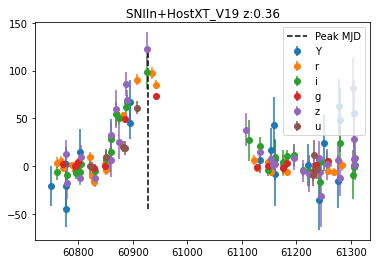

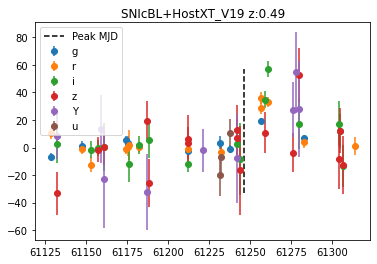

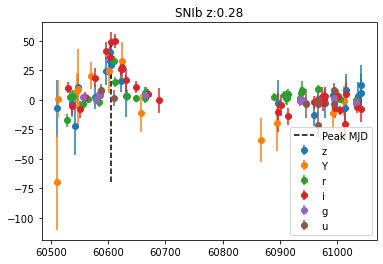

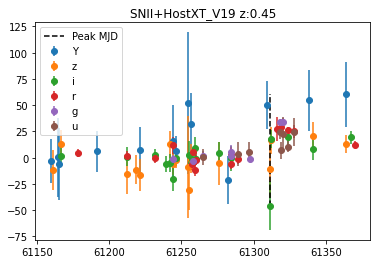

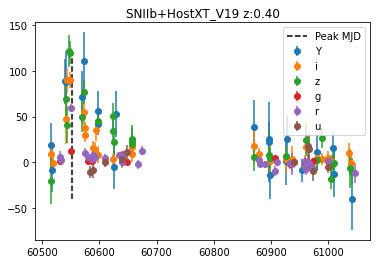

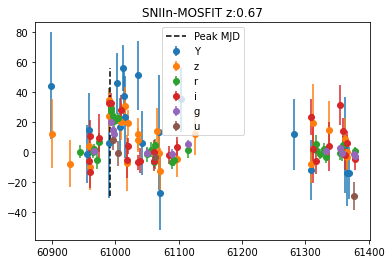

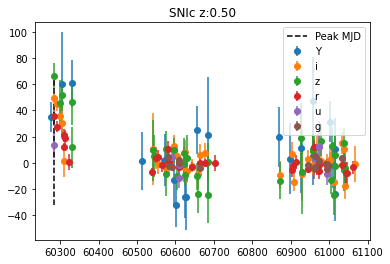

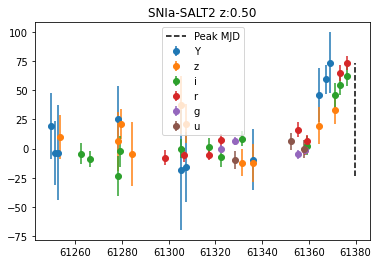

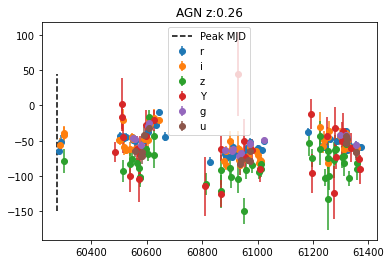

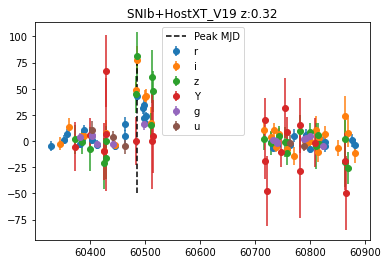

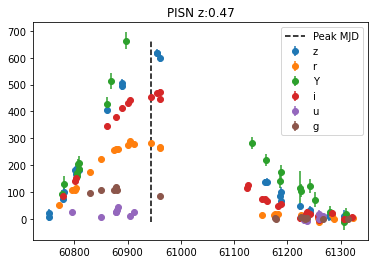

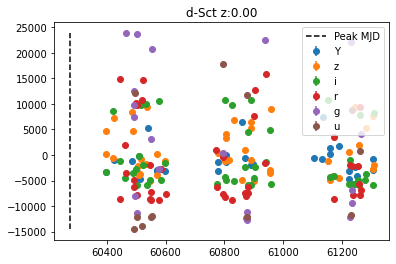

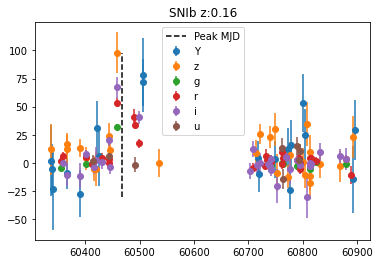

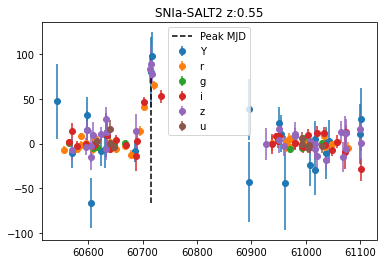

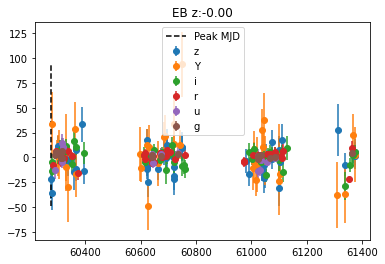

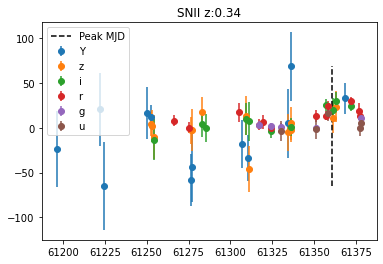

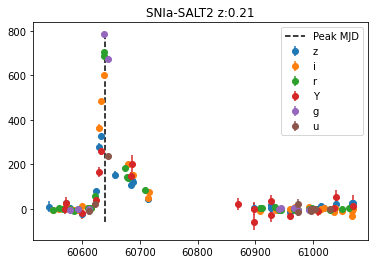

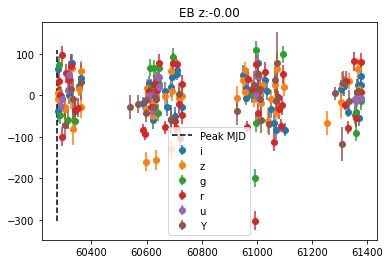

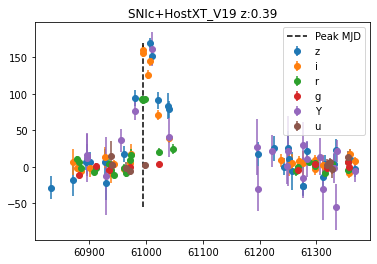

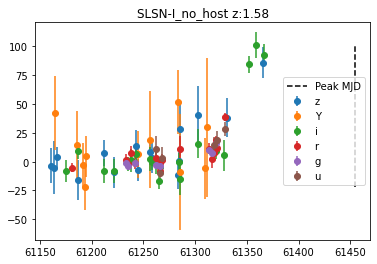

In [9]:
for snid in df_phot.SNID.unique()[np.random.randint(0, high=len(df_phot.SNID.unique()), size=20)]:
    plot_lc(df_phot,df_head,snid)

# PHOTFLAG
can we use the same filtering than DES?
DES  filters 8 16 32 64 128 256 512

In [15]:
df_phot.PHOTFLAG.unique()

array([   0, 6144, 4096, 1024], dtype=int32)

In [11]:
df_phot.groupby(by='PHOTFLAG')['MJD'].count()

PHOTFLAG
0       58136528
1024        1447
4096     8613272
6144      506567
Name: MJD, dtype: int64


0 non detection?

+= 4096 for detection (roughly SNR>5)

+= 2048 trigger (1st detection) -> PHOTFLAG=6144

+= 1024 saturation (>100,000 pe in central pixel)

looks like the photo window around PEAKMJD I may loose a lot oh photometry. Lets get some stats

In [12]:
df_phot = pd.merge(df_phot,df_head[['SNID','PEAKMJD']], on='SNID',how='left')

In [13]:
mask = df_phot["MJD"] != -777.00
df_phot["window_delta_time"] = df_phot["MJD"] - df_phot['PEAKMJD']
df_phot.loc[mask, "window_time_cut"] = df_phot["window_delta_time"].apply(
lambda x: True
if (x > 0 and x < 100)
else (True if (x <= 0 and x > -30) else False)
)
df_timecut = df_phot[df_phot["window_time_cut"] == True]

is there a preference for a type of event that we loose most photometry?

In [14]:
tmp_timecut = df_head[df_head.SNID.isin(df_timecut.SNID.values)].groupby(by='SIM_TYPE_INDEX')['SIM_TYPE_INDEX'].count()
tmp_all = df_head.groupby(by='SIM_TYPE_INDEX')['SIM_TYPE_INDEX'].count()
tmp = 100*(tmp_all - tmp_timecut) / tmp_all

In [15]:
df_tmp = pd.DataFrame()
df_tmp['percentage'] = tmp.values
df_tmp['ntyp'] = tmp.index.to_list()
df_tmp['typ'] = df_tmp['ntyp'].apply(lambda x: dic_type_decoder[x])

In [16]:
df_tmp

,percentage,ntyp,typ
0,0.274592,10,SNIa-SALT2
1,0.289387,11,SNIa-91bg
2,0.385031,12,SNIax
3,0.087466,20,SNIb
4,1.191058,21,SNIb+HostXT_V19
5,0.262009,25,SNIc
6,1.480893,26,SNIc+HostXT_V19
7,0.379082,27,SNIcBL+HostXT_V19
8,0.494246,30,SNII-NMF
9,1.305474,31,SNII


We loose ~30% microlensing events for each subclass + 20% PISN, AGN